In [1]:
!pip install torchmetrics
!pip install timm
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchmetrics
from torchmetrics import Dice, JaccardIndex
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2 # np.array -> torch.tensor
import os
from tqdm import tqdm
from glob import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
from functools import partial

from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.registry import register_model
from timm.models.vision_transformer import _cfg
import math

In [3]:
# Mount drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Prepare Data**

100%|██████████| 3929/3929 [00:00<00:00, 979053.02it/s]


(256, 256) 0
[0]


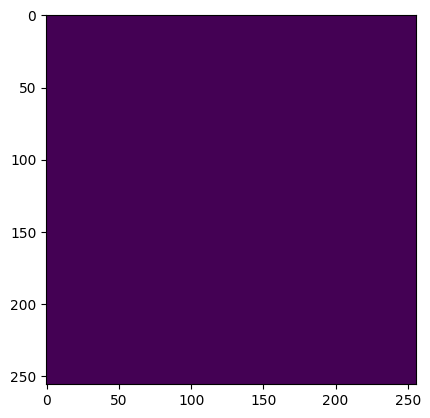

In [4]:
mask_files = glob('/content/gdrive/MyDrive/Brain_Tumor/input/lgg-mri-segmentation/kaggle_3m/*/*_mask*')
image_files = [file.replace("_mask", "") for file in tqdm(mask_files)]

# Create a dataframe
df = pd.DataFrame({
    "image_path": image_files,
    "mask_path": mask_files,
})

# Read mask
mask = cv2.imread(mask_files[0], cv2.COLOR_BGR2GRAY)
plt.imshow(mask);
print(mask.shape, cv2.IMREAD_GRAYSCALE)
print(np.unique(mask))

(256, 256, 3)


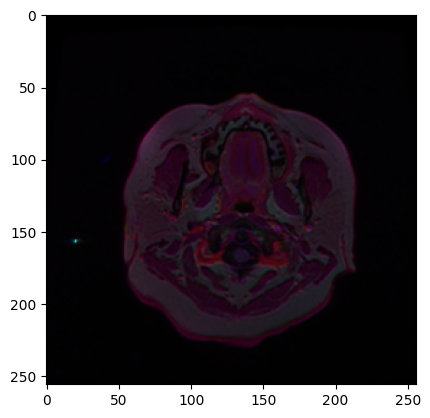

In [5]:
# Read image
image = cv2.imread(image_files[0])
plt.imshow(image)
print(image.shape)

**Split train, test, val dataset**

In [6]:
train_df, val_df = train_test_split(df, test_size=0.1, random_state=0)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_df, test_df = train_test_split(train_df, test_size=0.15, random_state=0)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(3005, 2)
(393, 2)
(531, 2)


In [7]:
val_df = val_df.iloc[:-3]
test_df = test_df.iloc[:-1]

In [8]:
test_df.shape

(530, 2)

**Transform Data**

In [9]:
train_transform = A.Compose(
    [
        A.Resize(256, 256),
        A.ShiftScaleRotate(
            shift_limit=0.2,
            scale_limit=0.2,
            rotate_limit=30,
            p=0.5
        ),
        A.RGBShift(
            r_shift_limit=25,
            g_shift_limit=25,
            b_shift_limit=25,
            p=0.5
        ),
        A.RandomBrightnessContrast(
            brightness_limit=0.3,
            contrast_limit=0.3,
            p=0.5
        ),
        A.Normalize(
            mean=(0.485, 0.456, 0.406),
            std=(0.229, 0.224, 0.225),
            max_pixel_value=255.0
        ),
        ToTensorV2(),
    ]
)
val_transform = A.Compose(
    [
        A.Resize(256, 256),
        A.Normalize(
            mean=(0.485, 0.456, 0.406),
            std=(0.229, 0.224, 0.225),
        ),
        ToTensorV2(), # numpy.array -> torch.tensor (B, 3, H, W)
    ]
)
test_transform = A.Compose(
    [
        A.Resize(256, 256),
        A.Normalize(
            mean=(0.485, 0.456, 0.406),
            std=(0.229, 0.224, 0.225),
        ),
        ToTensorV2(), # numpy.array -> torch.tensor (B, 3, H, W)

    ]
)

**Load Data**

In [10]:
class Load_Data(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx, 0])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(self.df.iloc[idx, 1])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

        mask[mask == 255] = 1

        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            transformed_image = transformed["image"]
            transformed_mask = transformed["mask"]
        return transformed_image, transformed_mask

In [11]:
train_dataset = Load_Data(train_df, transform=train_transform)
val_dataset = Load_Data(val_df, transform=val_transform)
test_dataset = Load_Data(test_df, transform=test_transform)

In [12]:
print(val_dataset.__len__())

390


**Test Dataload**

In [13]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

**Mô hình MSMA**

In [14]:
def unet_block(in_channels, out_channels):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, 3, 1, 1),
      nn.ReLU(),
      nn.Conv2d(out_channels, out_channels, 3, 1, 1),
      nn.ReLU()
  )

class Mlp(nn.Module):
    def __init__(
        self,
        in_features,
        hidden_features=None,
        out_features=None,
        act_layer=nn.GELU,
        drop=0.0,
        linear=False,
    ):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.dwconv = DWConv(hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)
        self.linear = linear
        if self.linear:
            self.relu = nn.ReLU(inplace=True)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=0.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):
        x = self.fc1(x)
        if self.linear:
            x = self.relu(x)
        x = self.dwconv(x, H, W)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(
        self,
        dim,
        num_heads=8,
        qkv_bias=False,
        qk_scale=None,
        attn_drop=0.0,
        proj_drop=0.0,
        sr_ratio=1,
        linear=False,
    ):
        super().__init__()
        assert (
            dim % num_heads == 0
        ), f"dim {dim} should be divided by num_heads {num_heads}."

        self.dim = dim
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim**-0.5

        self.q = nn.Linear(dim, dim, bias=qkv_bias)
        self.kv = nn.Linear(dim, dim * 2, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        self.linear = linear
        self.sr_ratio = sr_ratio
        if not linear:
            if sr_ratio > 1:
                self.sr = nn.Conv2d(dim, dim, kernel_size=sr_ratio, stride=sr_ratio)
                self.norm = nn.LayerNorm(dim)
        else:
            self.pool = nn.AdaptiveAvgPool2d(7)
            self.sr = nn.Conv2d(dim, dim, kernel_size=1, stride=1)
            self.norm = nn.LayerNorm(dim)
            self.act = nn.GELU()
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=0.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):
        B, N, C = x.shape
        q = (
            self.q(x)
            .reshape(B, N, self.num_heads, C // self.num_heads)
            .permute(0, 2, 1, 3)
        )

        if not self.linear:
            if self.sr_ratio > 1:
                x_ = x.permute(0, 2, 1).reshape(B, C, H, W)
                x_ = self.sr(x_).reshape(B, C, -1).permute(0, 2, 1)
                x_ = self.norm(x_)
                kv = (
                    self.kv(x_)
                    .reshape(B, -1, 2, self.num_heads, C // self.num_heads)
                    .permute(2, 0, 3, 1, 4)
                )
            else:
                kv = (
                    self.kv(x)
                    .reshape(B, -1, 2, self.num_heads, C // self.num_heads)
                    .permute(2, 0, 3, 1, 4)
                )
        else:
            x_ = x.permute(0, 2, 1).reshape(B, C, H, W)
            x_ = self.sr(self.pool(x_)).reshape(B, C, -1).permute(0, 2, 1)
            x_ = self.norm(x_)
            x_ = self.act(x_)
            kv = (
                self.kv(x_)
                .reshape(B, -1, 2, self.num_heads, C // self.num_heads)
                .permute(2, 0, 3, 1, 4)
            )
        k, v = kv[0], kv[1]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)

        return x


class Block(nn.Module):
    def __init__(
        self,
        dim,
        num_heads,
        mlp_ratio=4.0,
        qkv_bias=False,
        qk_scale=None,
        drop=0.0,
        attn_drop=0.0,
        drop_path=0.0,
        act_layer=nn.GELU,
        norm_layer=nn.LayerNorm,
        sr_ratio=1,
        linear=False,
    ):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim,
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            qk_scale=qk_scale,
            attn_drop=attn_drop,
            proj_drop=drop,
            sr_ratio=sr_ratio,
            linear=linear,
        )
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(
            in_features=dim,
            hidden_features=mlp_hidden_dim,
            act_layer=act_layer,
            drop=drop,
            linear=linear,
        )

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=0.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):
        x = x + self.drop_path(self.attn(self.norm1(x), H, W))
        x = x + self.drop_path(self.mlp(self.norm2(x), H, W))

        return x


class OverlapPatchEmbed(nn.Module):
    """Image to Patch Embedding"""

    def __init__(self, img_size=224, patch_size=7, stride=4, in_chans=3, embed_dim=768):
        super().__init__()

        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)

        assert max(patch_size) > stride, "Set larger patch_size than stride"

        self.img_size = img_size
        self.patch_size = patch_size
        self.H, self.W = img_size[0] // stride, img_size[1] // stride
        self.num_patches = self.H * self.W
        self.proj = nn.Conv2d(
            in_chans,
            embed_dim,
            kernel_size=patch_size,
            stride=stride,
            padding=(patch_size[0] // 2, patch_size[1] // 2),
        )
        self.norm = nn.LayerNorm(embed_dim)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=0.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x):
        x = self.proj(x)
        _, _, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)
        x = self.norm(x)

        return x, H, W


class PyramidVisionTransformerV2(nn.Module):
    def __init__(
        self,
        img_size=224,
        patch_size=16,
        in_chans=3,
        num_classes=1000,
        embed_dims=[64, 128, 256, 512],
        num_heads=[1, 2, 4, 8],
        mlp_ratios=[4, 4, 4, 4],
        qkv_bias=False,
        qk_scale=None,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.0,
        norm_layer=nn.LayerNorm,
        depths=[3, 4, 6, 3],
        sr_ratios=[8, 4, 2, 1],
        num_stages=4,
        linear=False,
    ):
        super().__init__()
        self.num_classes = num_classes
        self.depths = depths
        self.num_stages = num_stages

        dpr = [
            x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))
        ]  # stochastic depth decay rule
        cur = 0

        for i in range(num_stages):
            patch_embed = OverlapPatchEmbed(
                img_size=img_size if i == 0 else img_size // (2 ** (i + 1)),
                patch_size=7 if i == 0 else 3,
                stride=4 if i == 0 else 2,
                in_chans=in_chans if i == 0 else embed_dims[i - 1],
                embed_dim=embed_dims[i],
            )

            block = nn.ModuleList(
                [
                    Block(
                        dim=embed_dims[i],
                        num_heads=num_heads[i],
                        mlp_ratio=mlp_ratios[i],
                        qkv_bias=qkv_bias,
                        qk_scale=qk_scale,
                        drop=drop_rate,
                        attn_drop=attn_drop_rate,
                        drop_path=dpr[cur + j],
                        norm_layer=norm_layer,
                        sr_ratio=sr_ratios[i],
                        linear=linear,
                    )
                    for j in range(depths[i])
                ]
            )
            norm = norm_layer(embed_dims[i])
            cur += depths[i]

            setattr(self, f"patch_embed{i + 1}", patch_embed)
            setattr(self, f"block{i + 1}", block)
            setattr(self, f"norm{i + 1}", norm)

        # classification head
        self.head = (
            nn.Linear(embed_dims[3], num_classes) if num_classes > 0 else nn.Identity()
        )

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=0.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def freeze_patch_emb(self):
        self.patch_embed1.requires_grad = False

    @torch.jit.ignore
    def no_weight_decay(self):
        return {
            "pos_embed1",
            "pos_embed2",
            "pos_embed3",
            "pos_embed4",
            "cls_token",
        }  # has pos_embed may be better

    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes, global_pool=""):
        self.num_classes = num_classes
        self.head = (
            nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()
        )

    def forward_features(self, x):
        B = x.shape[0]

        for i in range(self.num_stages):
            patch_embed = getattr(self, f"patch_embed{i + 1}")
            block = getattr(self, f"block{i + 1}")
            norm = getattr(self, f"norm{i + 1}")
            x, H, W = patch_embed(x)
            for blk in block:
                x = blk(x, H, W)
            x = norm(x)
            if i != self.num_stages - 1:
                x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()

        return x.mean(dim=1)

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)

        return x


class DWConv(nn.Module):
    def __init__(self, dim=768):
        super(DWConv, self).__init__()
        self.dwconv = nn.Conv2d(dim, dim, 3, 1, 1, bias=True, groups=dim)

    def forward(self, x, H, W):
        B, N, C = x.shape
        x = x.transpose(1, 2).view(B, C, H, W)
        x = self.dwconv(x)
        x = x.flatten(2).transpose(1, 2)

        return x


def _conv_filter(state_dict, patch_size=16):
    """convert patch embedding weight from manual patchify + linear proj to conv"""
    out_dict = {}
    for k, v in state_dict.items():
        if "patch_embed.proj.weight" in k:
            v = v.reshape((v.shape[0], 3, patch_size, patch_size))
        out_dict[k] = v

    return out_dict


@register_model
def pvt_v2_b0(pretrained=False, **kwargs):
    model = PyramidVisionTransformerV2(
        patch_size=4,
        embed_dims=[32, 64, 160, 256],
        num_heads=[1, 2, 5, 8],
        mlp_ratios=[8, 8, 4, 4],
        qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6),
        depths=[2, 2, 2, 2],
        sr_ratios=[8, 4, 2, 1],
        **kwargs,
    )
    model.default_cfg = _cfg()

    return model


@register_model
def pvt_v2_b1(pretrained=False, **kwargs):
    model = PyramidVisionTransformerV2(
        patch_size=4,
        embed_dims=[64, 128, 320, 512],
        num_heads=[1, 2, 5, 8],
        mlp_ratios=[8, 8, 4, 4],
        qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6),
        depths=[2, 2, 2, 2],
        sr_ratios=[8, 4, 2, 1],
        **kwargs,
    )
    model.default_cfg = _cfg()

    return model


@register_model
def pvt_v2_b2(pretrained=False, **kwargs):
    model = PyramidVisionTransformerV2(
        patch_size=4,
        embed_dims=[64, 128, 320, 512],
        num_heads=[1, 2, 5, 8],
        mlp_ratios=[8, 8, 4, 4],
        qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6),
        depths=[3, 4, 6, 3],
        sr_ratios=[8, 4, 2, 1],
        **kwargs,
    )
    model.default_cfg = _cfg()

    return model


@register_model
def pvt_v2_b3(pretrained=False, **kwargs):
    model = PyramidVisionTransformerV2(
        patch_size=4,
        embed_dims=[64, 128, 320, 512],
        num_heads=[1, 2, 5, 8],
        mlp_ratios=[8, 8, 4, 4],
        qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6),
        depths=[3, 4, 18, 3],
        sr_ratios=[8, 4, 2, 1],
        **kwargs,
    )
    model.default_cfg = _cfg()

    return model


@register_model
def pvt_v2_b4(pretrained=False, **kwargs):
    model = PyramidVisionTransformerV2(
        patch_size=4,
        embed_dims=[64, 128, 320, 512],
        num_heads=[1, 2, 5, 8],
        mlp_ratios=[8, 8, 4, 4],
        qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6),
        depths=[3, 8, 27, 3],
        sr_ratios=[8, 4, 2, 1],
        **kwargs,
    )
    model.default_cfg = _cfg()

    return model


@register_model
def pvt_v2_b5(pretrained=False, **kwargs):
    model = PyramidVisionTransformerV2(
        patch_size=4,
        embed_dims=[64, 128, 320, 512],
        num_heads=[1, 2, 5, 8],
        mlp_ratios=[4, 4, 4, 4],
        qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6),
        depths=[3, 6, 40, 3],
        sr_ratios=[8, 4, 2, 1],
        **kwargs,
    )
    model.default_cfg = _cfg()

    return model


@register_model
def pvt_v2_b2_li(pretrained=False, **kwargs):
    model = PyramidVisionTransformerV2(
        patch_size=4,
        embed_dims=[64, 128, 320, 512],
        num_heads=[1, 2, 5, 8],
        mlp_ratios=[8, 8, 4, 4],
        qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6),
        depths=[3, 4, 6, 3],
        sr_ratios=[8, 4, 2, 1],
        linear=True,
        **kwargs,
    )
    model.default_cfg = _cfg()

    return model


backbone = PyramidVisionTransformerV2(
    patch_size=4,
    embed_dims=[64, 128, 320, 512],
    num_heads=[1, 2, 5, 8],
    mlp_ratios=[8, 8, 4, 4],
    qkv_bias=True,
    norm_layer=partial(torch.nn.LayerNorm, eps=1e-6),
    depths=[3, 4, 18, 3],
    sr_ratios=[8, 4, 2, 1],
)
backbone.load_state_dict(
    torch.load(
        "/content/gdrive/MyDrive/My_Project/MSMA-Net/pretrained_model/pvt_v2_b3.pth"
    )
)


class _ASPPModule(nn.Module):
    def __init__(self, inplanes, planes, kernel_size, padding, dilation, BatchNorm):
        super().__init__()
        self.atrous_conv = nn.Conv2d(
            inplanes,
            planes,
            kernel_size=kernel_size,
            stride=1,
            padding=padding,
            dilation=dilation,
            bias=False,
        )
        self.bn = BatchNorm(planes)
        self.silu = nn.SiLU(inplace=True)
        self._init_weight()

    def forward(self, x):
        x = self.atrous_conv(x)
        x = self.bn(x)

        return self.silu(x)

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()


class ASPP(nn.Module):
    def __init__(self, inplanes, outplanes, output_stride, BatchNorm):
        super().__init__()
        if output_stride == 4:
            dilations = [1, 6, 12, 18]
        elif output_stride == 8:
            dilations = [1, 4, 6, 10]
        elif output_stride == 2:
            dilations = [1, 12, 24, 36]
        else:
            raise NotImplementedError

        # self.aspp1 = _ASPPModule(inplanes, outplanes, 1, padding=0,dilation=dilations[0], BatchNorm=BatchNorm)
        self.aspp2 = _ASPPModule(
            inplanes,
            outplanes,
            3,
            padding=dilations[1],
            dilation=dilations[1],
            BatchNorm=BatchNorm,
        )
        self.aspp3 = _ASPPModule(
            inplanes,
            outplanes,
            3,
            padding=dilations[2],
            dilation=dilations[2],
            BatchNorm=BatchNorm,
        )
        self.aspp4 = _ASPPModule(
            inplanes,
            outplanes,
            3,
            padding=dilations[3],
            dilation=dilations[3],
            BatchNorm=BatchNorm,
        )

        self.global_avg_pool = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Conv2d(inplanes, outplanes, 1, stride=1, bias=False),
            # BatchNorm(outplanes),
            nn.SiLU(inplace=True),
        )
        self.conv1 = nn.Conv2d(outplanes * 4, outplanes, 1, bias=False)
        self.bn1 = BatchNorm(outplanes)
        self.silu = nn.SiLU(inplace=True)
        self.dropout = nn.Dropout(0.0)
        self._init_weight()

    def forward(self, x):
        # x1 = self.aspp1(x)
        x2 = self.aspp2(x)
        x3 = self.aspp3(x)
        x4 = self.aspp4(x)
        x5 = self.global_avg_pool(x)
        x5 = F.interpolate(x5, size=x4.size()[2:], mode="bilinear", align_corners=True)
        x = torch.cat((x2, x3, x4, x5), dim=1)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.silu(x)

        return self.dropout(x)

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()


class PASPP(nn.Module):
    def __init__(self, inplanes, outplanes, output_stride=4, BatchNorm=nn.BatchNorm2d):
        super().__init__()
        if output_stride == 4:
            dilations = [1, 6, 12, 18]
        elif output_stride == 8:
            dilations = [1, 4, 6, 10]
        elif output_stride == 2:
            dilations = [1, 12, 24, 36]
        elif output_stride == 16:
            dilations = [1, 2, 3, 4]
        elif output_stride == 1:
            dilations = [1, 16, 32, 48]
        else:
            raise NotImplementedError
        self._norm_layer = BatchNorm
        self.silu = nn.SiLU(inplace=True)
        self.conv1 = self._make_layer(inplanes, inplanes // 4)
        self.conv2 = self._make_layer(inplanes, inplanes // 4)
        self.conv3 = self._make_layer(inplanes, inplanes // 4)
        self.conv4 = self._make_layer(inplanes, inplanes // 4)
        self.atrous_conv1 = nn.Conv2d(
            inplanes // 4,
            inplanes // 4,
            kernel_size=3,
            dilation=dilations[0],
            padding=dilations[0],
        )
        self.atrous_conv2 = nn.Conv2d(
            inplanes // 4,
            inplanes // 4,
            kernel_size=3,
            dilation=dilations[1],
            padding=dilations[1],
        )
        self.atrous_conv3 = nn.Conv2d(
            inplanes // 4,
            inplanes // 4,
            kernel_size=3,
            dilation=dilations[2],
            padding=dilations[2],
        )
        self.atrous_conv4 = nn.Conv2d(
            inplanes // 4,
            inplanes // 4,
            kernel_size=3,
            dilation=dilations[3],
            padding=dilations[3],
        )
        self.conv5 = self._make_layer(inplanes // 2, inplanes // 2)
        self.conv6 = self._make_layer(inplanes // 2, inplanes // 2)
        self.convout = self._make_layer(inplanes, inplanes)

    def _make_layer(self, inplanes, outplanes):
        layer = []
        layer.append(nn.Conv2d(inplanes, outplanes, kernel_size=1))
        layer.append(self._norm_layer(outplanes))
        layer.append(self.silu)
        return nn.Sequential(*layer)

    def forward(self, X):
        x1 = self.conv1(X)
        x2 = self.conv2(X)
        x3 = self.conv3(X)
        x4 = self.conv4(X)

        x12 = torch.add(x1, x2)
        x34 = torch.add(x3, x4)

        x1 = torch.add(self.atrous_conv1(x1), x12)
        x2 = torch.add(self.atrous_conv2(x2), x12)
        x3 = torch.add(self.atrous_conv3(x3), x34)
        x4 = torch.add(self.atrous_conv4(x4), x34)

        x12 = torch.cat([x1, x2], dim=1)
        x34 = torch.cat([x3, x4], dim=1)

        x12 = self.conv5(x12)
        x34 = self.conv5(x34)
        x = torch.cat([x12, x34], dim=1)
        x = self.convout(x)
        return x


class spatial_attention(nn.Module):
    def __init__(self, kernel_size=3):
        super(spatial_attention, self).__init__()

        assert kernel_size in (3, 7), "kernel size must be 3 or 7"
        padding = 3 if kernel_size == 7 else 1

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x0 = x
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return x0 * self.sigmoid(x)


class channel_attention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(channel_attention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc1 = nn.Conv2d(in_planes, in_planes // 16, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Conv2d(in_planes // 16, in_planes, 1, bias=False)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x0 = x
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return x0 * self.sigmoid(out)


class AttentionModule(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv0 = nn.Conv2d(dim, dim, 5, padding=2, groups=dim)
        self.conv0_1 = nn.Conv2d(dim, dim, (1, 3), padding=(0, 1), groups=dim)
        self.conv0_2 = nn.Conv2d(dim, dim, (3, 1), padding=(1, 0), groups=dim)

        self.conv1_1 = nn.Conv2d(dim, dim, (1, 5), padding=(0, 2), groups=dim)
        self.conv1_2 = nn.Conv2d(dim, dim, (5, 1), padding=(2, 0), groups=dim)

        self.conv2_1 = nn.Conv2d(dim, dim, (1, 7), padding=(0, 3), groups=dim)
        self.conv2_2 = nn.Conv2d(dim, dim, (7, 1), padding=(3, 0), groups=dim)
        # self.conv3_1 = nn.Conv2d(
        # dim, dim, (1, 9), padding=(0, 4), groups=dim)
        # self.conv3_2 = nn.Conv2d(
        #   dim, dim, (9, 1), padding=(4, 0), groups=dim)
        self.conv3 = nn.Conv2d(4 * dim, dim, 1)  # nn.Conv2d(5*dim, dim, 1)
        # self.SE = SEAttention(dim)
        # self.pwc=nn.Conv2d(dim, dim, 1)
        self.c1 = nn.Sequential(
            nn.Conv2d(dim, dim, kernel_size=1, padding=0), channel_attention(dim)
        )
        self.c2 = nn.Sequential(
            nn.Conv2d(dim, dim, kernel_size=(3, 3), padding=3, dilation=3),
            channel_attention(dim),
        )
        self.c3 = nn.Sequential(
            nn.Conv2d(dim, dim, kernel_size=(3, 3), padding=5, dilation=5),
            channel_attention(dim),
        )
        self.c4 = nn.Sequential(
            nn.Conv2d(dim, dim, kernel_size=(3, 3), padding=7, dilation=7),
            channel_attention(dim),
        )
        # self.c5 = nn.Sequential(nn.Conv2d(dim,dim, kernel_size=(3, 3), padding=9, dilation=9), channel_attention(dim))
        self.act = nn.ReLU()
        self.sa = spatial_attention()  # change
        # self.norm=nn.BatchNorm2d(dim)

    def forward(self, x):
        u = x.clone()
        attn = self.conv0(x)
        # attn_=self.SE(attn)
        attn_ = self.c1(attn)

        attn_0 = self.conv0_1(attn)
        attn_0 = self.conv0_2(attn_0)
        attn_0 = self.c2(attn_0)

        attn_1 = self.conv1_1(attn)
        attn_1 = self.conv1_2(attn_1)
        attn_1 = self.c3(attn_1)

        attn_2 = self.conv2_1(attn)
        attn_2 = self.conv2_2(attn_2)
        attn_2 = self.c4(attn_2)

        # attn_3 = self.conv3_1(attn)
        # attn_3 = self.conv3_2(attn)
        # attn_3 = self.c5(attn_3)

        attn_cat = torch.cat((attn_, attn_0, attn_1, attn_2), dim=1)  # attn_3

        attn_add = self.conv3(attn_cat) + attn_
        attn_spa = self.act(attn_add)
        attn_spa = self.sa(attn_spa)
        # attn_spa=self.norm(attn_spa)#add norm
        return attn_spa


class MSCAttention(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model
        self.proj_1 = nn.Conv2d(d_model, d_model, 1)
        self.activation = nn.GELU()
        self.spatial_gating_unit = AttentionModule(d_model)
        self.proj_2 = nn.Conv2d(d_model, d_model, 1)
        self.norm = nn.BatchNorm2d(d_model)  # change

    def forward(self, x):
        shorcut = x.clone()
        x = self.proj_1(x)
        x = self.activation(x)
        x = self.spatial_gating_unit(x)
        x = self.proj_2(x)
        x = x + self.norm(shorcut)  # change
        return x


class RB(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.in_layers = nn.Sequential(
            nn.GroupNorm(32, in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        )

        self.out_layers = nn.Sequential(
            nn.GroupNorm(32, out_channels),
            nn.SiLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        )

        if out_channels == in_channels:
            self.skip = nn.Identity()
        else:
            self.skip = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        h = self.in_layers(x)
        h = self.out_layers(h)
        return h + self.skip(x)


class LP(nn.Module):
    """
    Linear Prediction
    """

    def __init__(self, input_dim=2048, embed_dim=768):
        super().__init__()
        self.proj = nn.Linear(input_dim, embed_dim)

    def forward(self, x):
        B, _, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)
        x = self.proj(x)
        return x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()


class MLP(nn.Module):
    """
    Linear Embedding
    """

    def __init__(self, input_dim=2048, embed_dim=768):
        super().__init__()
        self.proj = nn.Linear(input_dim, embed_dim)
        self.act = nn.GELU()
        self.proj_re = nn.Linear(embed_dim, input_dim)

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)
        x = self.proj(x)
        x = self.act(x)
        x = self.proj_re(x)
        x = x.reshape(B, C, H, W)
        return x


from einops import rearrange, repeat
from einops.layers.torch import Rearrange, Reduce
import torch
from torch import nn, Tensor
from torch.nn import functional as F
from einops import rearrange


# class MLP(nn.Module):
#   def __init__(self, dim=2048, embed_dim=768):
#      super().__init__()
#     self.proj = nn.Linear(dim, embed_dim)

# def forward(self, x: Tensor) -> Tensor:
##   x = x.flatten(2).transpose(1, 2)
#   x = self.proj(x)
#   return x


class PatchEmbed(nn.Module):
    def __init__(self, patch_size=4, in_ch=3, dim=96, type="pool") -> None:
        super().__init__()
        self.patch_size = patch_size
        self.type = type
        self.dim = dim

        if type == "conv":
            self.proj = nn.Conv2d(
                in_ch, dim, patch_size, patch_size, groups=patch_size * patch_size
            )
        else:
            self.proj = nn.ModuleList(
                [
                    nn.MaxPool2d(patch_size, patch_size),
                    nn.AvgPool2d(patch_size, patch_size),
                ]
            )

        self.norm = nn.LayerNorm(dim)

    def forward(self, x: Tensor) -> Tensor:
        _, _, H, W = x.shape
        if W % self.patch_size != 0:
            x = F.pad(x, (0, self.patch_size - W % self.patch_size))
        if H % self.patch_size != 0:
            x = F.pad(x, (0, 0, 0, self.patch_size - H % self.patch_size))

        if self.type == "conv":
            x = self.proj(x)
        else:
            x = 0.5 * (self.proj[0](x) + self.proj[1](x))
        Wh, Ww = x.size(2), x.size(3)
        x = x.flatten(2).transpose(1, 2)
        x = self.norm(x)
        x = x.transpose(1, 2).view(-1, self.dim, Wh, Ww)
        return x


class LawinAttn(nn.Module):
    def __init__(self, in_ch=512, head=4, patch_size=8, reduction=2) -> None:
        super().__init__()
        self.head = head

        self.position_mixing = nn.ModuleList(
            [
                nn.Linear(patch_size * patch_size, patch_size * patch_size)
                for _ in range(self.head)
            ]
        )

        self.inter_channels = max(in_ch // reduction, 1)
        self.g = nn.Conv2d(in_ch, self.inter_channels, 1)
        self.theta = nn.Conv2d(in_ch, self.inter_channels, 1)
        self.phi = nn.Conv2d(in_ch, self.inter_channels, 1)
        self.conv_out = nn.Sequential(
            nn.Conv2d(self.inter_channels, in_ch, 1, bias=False), nn.BatchNorm2d(in_ch)
        )

    def forward(self, query: Tensor, context: Tensor) -> Tensor:
        B, C, H, W = context.shape
        context = context.reshape(B, C, -1)
        context_mlp = []

        for i, pm in enumerate(self.position_mixing):
            context_crt = context[
                :, (C // self.head) * i : (C // self.head) * (i + 1), :
            ]
            context_mlp.append(pm(context_crt))

        context_mlp = torch.cat(context_mlp, dim=1)
        context = context + context_mlp
        context = context.reshape(B, C, H, W)

        g_x = self.g(context).view(B, self.inter_channels, -1)
        g_x = rearrange(g_x, "b (h dim) n -> (b h) dim n", h=self.head)
        g_x = g_x.permute(0, 2, 1)

        theta_x = self.theta(query).view(B, self.inter_channels, -1)
        theta_x = rearrange(theta_x, "b (h dim) n -> (b h) dim n", h=self.head)
        theta_x = theta_x.permute(0, 2, 1)

        phi_x = self.phi(context).view(B, self.inter_channels, -1)
        phi_x = rearrange(phi_x, "b (h dim) n -> (b h) dim n", h=self.head)

        pairwise_weight = torch.matmul(theta_x, phi_x)
        pairwise_weight /= theta_x.shape[-1] ** 0.5
        pairwise_weight = pairwise_weight.softmax(dim=-1)

        y = torch.matmul(pairwise_weight, g_x)
        y = rearrange(y, "(b h) n dim -> b n (h dim)", h=self.head)
        y = (
            y.permute(0, 2, 1)
            .contiguous()
            .reshape(B, self.inter_channels, *query.shape[-2:])
        )

        output = query + self.conv_out(y)
        return output


class ConvModule(nn.Module):
    def __init__(self, c1, c2):
        super().__init__()
        self.conv = nn.Conv2d(c1, c2, 1, bias=False)
        self.bn = nn.BatchNorm2d(c2)  # use SyncBN in original
        self.activate = nn.ReLU(True)

    def forward(self, x: Tensor) -> Tensor:
        return self.activate(self.bn(self.conv(x)))


class LawinHead(nn.Module):
    def __init__(self, embed_dim=512, num_classes=19) -> None:
        super().__init__()
        # for i, dim in enumerate(in_channels):
        #      self.add_module(f"linear_c{i+1}", MLP(dim, 48 if i == 0 else embed_dim))

        self.lawin_8 = LawinAttn(embed_dim, 64)
        self.lawin_4 = LawinAttn(embed_dim, 16)
        self.lawin_2 = LawinAttn(embed_dim, 4)
        self.ds_8 = PatchEmbed(8, embed_dim, embed_dim)
        self.ds_4 = PatchEmbed(4, embed_dim, embed_dim)
        self.ds_2 = PatchEmbed(2, embed_dim, embed_dim)

        self.image_pool = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), nn.Conv2d(embed_dim, embed_dim, 1), nn.ReLU(True)
        )
        self.linear_fuse = ConvModule(embed_dim * 3, embed_dim)
        self.short_path = ConvModule(embed_dim, embed_dim)
        self.cat = ConvModule(embed_dim * 5, embed_dim)

        self.low_level_fuse = ConvModule(embed_dim + 48, embed_dim)
        self.linear_pred = nn.Conv2d(embed_dim, num_classes, 1)
        self.dropout = nn.Dropout2d(0.1)

    def get_lawin_att_feats(self, x: Tensor, patch_size: int):
        _, _, H, W = x.shape
        query = F.unfold(x, patch_size, stride=patch_size)
        query = rearrange(
            query,
            "b (c ph pw) (nh nw) -> (b nh nw) c ph pw",
            ph=patch_size,
            pw=patch_size,
            nh=H // patch_size,
            nw=W // patch_size,
        )
        outs = []

        for r in [8, 4, 2]:
            context = F.unfold(
                x,
                patch_size * r,
                stride=patch_size,
                padding=int((r - 1) / 2 * patch_size),
            )
            context = rearrange(
                context,
                "b (c ph pw) (nh nw) -> (b nh nw) c ph pw",
                ph=patch_size * r,
                pw=patch_size * r,
                nh=H // patch_size,
                nw=W // patch_size,
            )
            context = getattr(self, f"ds_{r}")(context)
            output = getattr(self, f"lawin_{r}")(query, context)
            output = rearrange(
                output,
                "(b nh nw) c ph pw -> b c (nh ph) (nw pw)",
                ph=patch_size,
                pw=patch_size,
                nh=H // patch_size,
                nw=W // patch_size,
            )
            outs.append(output)
        return outs

    def forward(self, features):
        B, _, H, W = features.shape
        feat = features
        ## Lawin attention spatial pyramid pooling
        feat_short = self.short_path(feat)
        feat_pool = F.interpolate(
            self.image_pool(feat), size=(H, W), mode="bilinear", align_corners=False
        )
        feat_lawin = self.get_lawin_att_feats(feat, 8)
        output = self.cat(torch.cat([feat_short, feat_pool, *feat_lawin], dim=1))

        ## Low-level feature enhancement
        # c1 = self.linear_c1(features[0]).permute(0, 2, 1).reshape(B, -1, *features[0].shape[-2:])
        # output = F.interpolate(output, size=features[0].shape[-2:], mode='bilinear', align_corners=False)
        # fused = self.low_level_fuse(torch.cat([output, c1], dim=1))

        # seg = self.linear_pred(self.dropout(fused))
        return output


class Net2(nn.Module):
    def __init__(self, backbone, d_model=(64, 128, 256, 512), depths=(16, 32, 32, 64)):
        super().__init__()
        self.backbone = torch.nn.Sequential(*list(backbone.children()))[:-1]
        for i in [1, 4, 7, 10]:
            self.backbone[i] = torch.nn.Sequential(*list(self.backbone[i].children()))
        self.d_model = d_model
        # self.down=nn.Sequential(MBConv(3,64),MBConv(64,128),MBConv(128,256),MBConv(256,512),nn.AvgPool2d(2))
        self.attention0 = MSCAttention(64)  # CBAMBlock(channel=64)#MSCAttention(64)
        self.attention1 = MSCAttention(128)  # CBAMBlock(channel=128)#MSCAttention(128)
        self.attention2 = MSCAttention(320)  # CBAMBlock(channel=256)#MSCAttention(256)
        self.attention3 = MSCAttention(512)  # CBAMBlock(channel=512)#MSCAttention(512)
        # self.PLAM0=PixLevelModule(64)
        # self.PLAM1=PixLevelModule(128)
        # self.PLAM2=PixLevelModule(256)
        # self.PLAM3=PixLevelModule(512)
        # self.stem=torch.nn.Sequential(*list(backbone.stem.children()))
        self.paspp = PASPP(inplanes=512, outplanes=512)
        # self.PLAM=PixLevelModule
        self.mlp3 = MLP(512, 768)
        self.mlp2 = MLP(320, 768)
        self.mlp1 = MLP(128, 768)
        self.mlp0 = LP(64, 32)
        self.linear_fuse = ConvModule(256, 512)
        self.lawin = LawinHead()
        self.RB = RB(64, 64)
        # self.LE = nn.ModuleList([])
        # self.SE0=SEAttention(channel=64)
        # self.SE1=SEAttention(channel=128)
        # self.SE2=SEAttention(channel=256)
        # self.SE3=SEAttention(channel=512)
        # for i in range(4):
        # self.LE.append(nn.Sequential(
        #          RB([128, 192, 320, 512][i], 64), RB(64, 64), nn.Upsample(size=64)
        #      ))

        self.Multi = nn.ModuleList([])
        for i in range(4):
            self.Multi.append(
                nn.Sequential(
                    RB([512, 384, 512, 512][i], [64, 64, 64, 64][i]),
                    RB(64, 64),
                    nn.Upsample(size=depths[i]),
                )
            )
        self.Up = nn.Upsample(size=256)
        self.Up1 = nn.Upsample(size=64)
        self.Near = nn.Sequential(RB(544, 64), RB(64, 64))
        self.End = nn.Sequential(
            RB(64, 64), RB(64, 64), nn.Conv2d(64, 1, kernel_size=1)
        )

    def get_pyramid(self, x):
        pyramid = []
        B = x.shape[0]
        for i, module in enumerate(self.backbone):
            if i in [0, 3, 6, 9]:
                x, H, W = module(x)
            elif i in [1, 4, 7, 10]:
                for sub_module in module:
                    x = sub_module(x, H, W)
            else:
                x = module(x)
                x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
                pyramid.append(x)
        return pyramid

    def forward(self, x):
        # branch_new=self.down(x)
        # pyramid_emp=[]
        pyramid = self.get_pyramid(x)
        pyramid[3] = self.paspp(pyramid[3])
        # for i,feat in enumerate(pyramid):
        #   attn=self.attention[i](pyramid[i])
        #  pyramid_emp.append(self.PLAM[i](attn))
        pyramid0 = self.attention0(pyramid[0])  # 64,64,64
        pyramid1 = self.attention1(pyramid[1])  # 128,32,32
        pyramid2 = self.attention2(pyramid[2])  # 320,16,16
        pyramid3 = self.attention3(pyramid[3])  # 512,8,8
        py3 = self.mlp3(pyramid3)
        py2 = self.mlp2(pyramid2)
        py1 = self.mlp1(pyramid1)
        py0 = self.mlp0(pyramid0)
        py3mix = self.Multi[0](py3)
        py3mix_adv = self.Multi[2](py3)  # 64,32,32
        py3cat = torch.cat((py3mix, py2), dim=1)  # 384,16,16
        py2mix = self.Multi[1](py3cat)  # 64,32,32
        py2cat = torch.cat((py2mix, py1, py3mix_adv), dim=1)  # 256,32,32
        ##
        input = self.linear_fuse(py2cat)  # 512,32,32
        output = self.lawin(input)  # 512,32,32
        # py1mix=self.Multi[2](py2cat)
        # py1cat=torch.cat((py1mix,py0),dim=1)
        # low-level enhancement
        # output=self.Multi[3](output)
        output = self.Up1(output)  # 512,64,64
        feat = torch.cat((output, py0), dim=1)  # 560,64,64
        feat = self.Near(feat)  # 512,64,64
        feat = self.RB(self.RB(feat))
        # py0__=self.mlp1(py1cat)
        # py1__=self.LE[1](py2cat)
        # py2__=self.LE[2](py3cat)
        # py3__=self.LE[3](py3)
        feat_concat = self.Up(feat)
        out = self.End(feat_concat)
        return out

**Test model**

In [15]:
model = Net2(backbone)

trainsize = 256
x = torch.rand(4, 3, trainsize, trainsize)
print("Input shape = ", x.shape)
y = model(x)
print("Output shape = ", y.shape)

Input shape =  torch.Size([4, 3, 256, 256])
Output shape =  torch.Size([4, 1, 256, 256])


In [16]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [17]:
#accuracy fn
def accuracy_function(preds, targets):
    preds_flat = preds.flatten()
    targets_flat = targets.flatten()
    acc = torch.sum(preds_flat == targets_flat)
    return acc/targets_flat.shape[0]

In [18]:
#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#load data
batch_size = 10
n_workers = os.cpu_count()
print("num_workers =", n_workers)

trainloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_workers
)

valloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=n_workers
)

testloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=n_workers
)

dataloader_dict = {"train": trainloader, "val": valloader}

#model
model = Net2(backbone).to(device)

#loss
criterior = nn.BCEWithLogitsLoss()

#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 5

#metrics
dice_fn = torchmetrics.Dice(num_classes=2, average="macro").to(device)
iou_fn = torchmetrics.JaccardIndex(num_classes=2, task="binary", average="macro").to(device)

#meter
train_acc_meter = AverageMeter()
train_loss_meter = AverageMeter()
train_dice_meter = AverageMeter()
train_iou_meter = AverageMeter()
val_iou_meter = AverageMeter()
val_dice_meter = AverageMeter()
val_loss_meter =  AverageMeter()

best_val_loss = float('inf')
best_params = None
best_params_path = "/content/gdrive/MyDrive/My_Project/MSMA-Net/model_MSMA.pth"

num_workers = 2


In [19]:
# for epoch in range(num_epochs):
#     # Train
#     model.train()
#     train_acc_meter.reset()
#     train_loss_meter.reset()
#     train_dice_meter.reset()
#     train_iou_meter.reset()

#     for inputs, labels in tqdm(trainloader):
#       optimizer.zero_grad()
#       n = inputs.shape[0]
#       inputs = inputs.to(device).float()
#       labels = labels.to(device).float()
#       outputs = model(inputs)
#       outputs = outputs.squeeze() # -> logit (-vc, +vc)
#       train_loss = criterior(outputs, labels)
#       train_loss.backward()
#       optimizer.step()

#       with torch.no_grad():
#         outputs_mask = outputs.sigmoid().round().long() # -> mask (0, 1)
#         train_dice_score = dice_fn(outputs_mask, labels.long())
#         train_iou_score = iou_fn(outputs_mask, labels.long())
#         train_accuracy = accuracy_function(outputs_mask, labels.long())

#         train_loss_meter.update(train_loss.item(), n)
#         train_iou_meter.update(train_iou_score.item(), n)
#         train_dice_meter.update(train_dice_score.item(), n)
#         train_acc_meter.update(train_accuracy.item(), n)

#     # Validation
#     model.eval()
#     val_iou_meter.reset()
#     val_dice_meter.reset()
#     val_loss_meter.reset()
#     with torch.no_grad():
#       for inputs, labels in tqdm(valloader):
#         optimizer.zero_grad()
#         n = inputs.shape[0]
#         inputs = inputs.to(device).float()
#         labels = labels.to(device).float()
#         outputs = model(inputs).to(device)
#         outputs = outputs.squeeze() # -> logit (-vc, +vc)
#         val_loss = criterior(outputs, labels)
#         outputs_mask = outputs.sigmoid().round().long()
#         val_dice_score = dice_fn(outputs_mask, labels.long())
#         val_iou_score = iou_fn(outputs_mask, labels.long())


#         val_dice_meter.update(val_dice_score.item(), n)
#         val_iou_meter.update(val_iou_score.item(), n)
#         val_loss_meter.update(val_loss.item(), n)

#     # Lưu lại bộ tham số tốt nhất
#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         best_params = model.state_dict()

#     print(f"\nEpoch {epoch+1}/{num_epochs}:")
#     print(f"Train Loss: {train_loss_meter.avg:.4f}", end=' ')
#     print(f"Train Acc: {train_acc_meter.avg:.4f}", end=' ')
#     print(f"Train Dice: {train_dice_meter.avg:.4f}", end=' ')
#     print(f"Train IoU: {train_iou_meter.avg:.4f}")
#     print(f"Val Loss: {val_loss_meter.avg:.4f}",end=' ')
#     print(f"Val Dice: {val_dice_meter.avg:.4f}", end=' ')
#     print(f"Val IoU: {val_iou_meter.avg:.4f}")

# torch.save(best_params, best_params_path)

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net2(backbone).to(device)
model.load_state_dict(torch.load("/content/gdrive/MyDrive/My_Project/MSMA-Net/model_MSMA.pth"))
test_iou_meter = AverageMeter()
test_dice_meter = AverageMeter()
with torch.no_grad():
    for batch_id, (x, y) in enumerate(tqdm(testloader), start=1):
        n = x.shape[0]
        x = x.to(device).float()
        y = y.to(device).float()
        y_hat = model(x)
        y_hat = y_hat.squeeze()
        y_hat_mask = y_hat.sigmoid().round().long()
        dice_score = dice_fn(y_hat_mask, y.long())
        iou_score = iou_fn(y_hat_mask, y.long())
        test_dice_meter.update(dice_score.item(), n)
        test_iou_meter.update(iou_score.item(), n)
print("TEST: IoU = {}, dice = {}".format(test_iou_meter.avg, test_dice_meter.avg))

100%|██████████| 53/53 [00:21<00:00,  2.44it/s]

TEST: IoU = nan, dice = 0.9133970894903507


In [ ]:
import random

model.eval()
idx = random.randint(200, 400)
with torch.no_grad():
    x, y = test_dataset[idx]
    # print(x.shape, y.shape) (C, H, W) -> (1, C, H, W) -> model
    x = x.to(device).float().unsqueeze(0)
    y_hat = model(x).squeeze() #(1, 1, H, W) -> (H, W)
    y_hat_mask = y_hat.sigmoid().round().long()
    # x, y, y_hat_mask
    plt.subplot(1, 3, 1)
    plt.imshow(unorm(x.squeeze().cpu()).permute(1, 2, 0)) # x (GPU) -> x(CPU)
    plt.subplot(1, 3, 2)
    plt.imshow(y)
    plt.subplot(1, 3, 3)
    plt.imshow(y_hat_mask.cpu())